In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from collections import Counter
import math
import random
import tqdm

#%matplotlib inline

In [3]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from imblearn.over_sampling import RandomOverSampler, SMOTE
from category_encoders import TargetEncoder

#### Helper Functions

In [5]:
def label_encoding_func(df_name, df_col_name):
    '''
    usage: dataframe[column_name] = label_encoding_function(dataframe, column_name)
    '''
    le = preprocessing.LabelEncoder()
    le.fit(df_name[df_col_name])
    return le.transform(df_name[df_col_name])

In [6]:
def do_one_hot_encoding(df_name, df_column_name, suffix=''):
    '''
    usage: dataframe[column_name] = do_one_hot_encoding(dataframe, column_name, suffix_for_column_name)
    '''
    x = pd.get_dummies(df_name[df_column_name])
    df_name = df_name.join(x, lsuffix=suffix)
    df_name = df_name.drop(df_column_name, axis=1) 
    return df_name

In [52]:
#function for perform target encoding later on
def perform_target_encoding(columns, X, Y, X_Val, X_Test):
    for i in tqdm.tqdm_notebook(columns):
        target_enc = TargetEncoder(cols=[i], smoothing=3)
        target_enc_fit = target_enc.fit(X, Y)
        X[i] = target_enc.transform(X, Y)[i]
        X_Val[i] = target_enc.transform(X_Val)[i]
        X_Test[i] = target_enc.transform(X_Test)[i]
        
    return X, X_Val, X_Test

#### Load Data

In [2]:
path = '../../feature_engineering_eda_data/' 
train_file = 'train_feature_engineered_V2.csv'
test_file = 'test_feature_engineered_V2.csv'

In [3]:
train_df = pd.read_csv(path+train_file)
test_df = pd.read_csv(path+test_file)
sample_submission = pd.read_csv(path+'sample_submission_24jSKY6.csv')

In [4]:
print(train_df.shape)
print(test_df.shape)

(233154, 55)
(112392, 54)


#### Sample Data

In [99]:
pd.set_option('display.max_columns', 100)

In [100]:
train_df.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,loan_default,F1_Manual_LTV,F2_difference_asset_disbursed,F3_avg_primary_sanctioned_amt,F4_avg_primary_disbursed_amt,F5_ratio_primary_active_overdue,F6_age_at_disbursal,F7.1_DOB_Y,F7.2_DOB_M,F7.3_DOB_D,F8.1_DisDate_Y,F8.2_DisDate_M,F8.3_DisDate_D,F9.1_AVG.ACCT.AGE_Y,F9.2_AVG.ACCT.AGE_M,F10.1_CREDIT.HIST_Y,F10.2_CREDIT.HIST_M
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,86.606164,7822,0.0,0.0,0.0,34.610959,1984,1,1,2018,8,3,0,0,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,0,1,71.922197,18405,50200.0,50200.0,1.0,33.178082,1985,7,31,2018,9,26,1,11,1,11
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,86.828553,8082,0.0,0.0,0.0,32.958904,1985,8,24,2018,8,1,0,0,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,1,1,86.991968,8600,0.0,0.0,0.0,24.838356,1993,12,30,2018,10,26,0,8,1,3
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,86.862355,7922,0.0,0.0,0.0,40.824658,1977,12,9,2018,9,26,0,0,0,0


In [101]:
test_df.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,F1_Manual_LTV,F2_difference_asset_disbursed,F3_avg_primary_sanctioned_amt,F4_avg_primary_disbursed_amt,F5_ratio_primary_active_overdue,F6_age_at_disbursal,F7.1_DOB_Y,F7.2_DOB_M,F7.3_DOB_D,F8.1_DisDate_Y,F8.2_DisDate_M,F8.3_DisDate_D,F9.1_AVG.ACCT.AGE_Y,F9.2_AVG.ACCT.AGE_M,F10.1_CREDIT.HIST_Y,F10.2_CREDIT.HIST_M
0,655269,53478,63558,86.54,67,22807,45,1497,01-01-74,Salaried,03-11-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,84.140470,10080,0.0,0.0,0.0,44.868493,1974,1,1,2018,11,3,0,0,0,0
1,723482,55513,63163,89.45,67,22807,45,1497,20-05-85,Self employed,20-11-18,6,1998,1,1,0,0,0,0,749,C-Very Low Risk,2,1,0,43898,48780,48780,0,0,0,0,0,0,5605,0,1,0,1,87.888479,7650,24390.0,24390.0,0.0,33.526027,1985,5,20,2018,11,20,0,8,1,0
2,758529,65282,84320,79.93,78,23135,86,2071,14-10-95,Salaried,29-11-18,4,1646,1,1,1,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,77.421727,19038,0.0,0.0,0.0,23.142466,1995,10,14,2018,11,29,0,0,0,0
3,763449,46905,63896,76.58,78,17014,45,2070,01-06-73,Self employed,29-11-18,4,1646,1,1,0,0,0,0,14,Not Scored: Only a Guarantor,1,1,1,132480,255000,255000,0,0,0,0,0,0,0,0,0,0,0,73.408351,16991,255000.0,255000.0,1.0,45.526027,1973,6,1,2018,11,29,2,5,2,5
4,708663,51428,63896,86.08,78,17014,45,2069,01-06-72,Salaried,17-11-18,4,1646,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,80.487041,12468,0.0,0.0,0.0,46.493151,1972,6,1,2018,11,17,0,0,0,0


## Data Cleaning / Exploration

#### Distribution of Target

0    0.782929
1    0.217071
Name: loan_default, dtype: float64


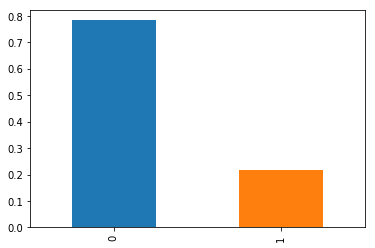

In [102]:
print(train_df['loan_default'].value_counts()/sum(train_df['loan_default'].value_counts()))
(train_df['loan_default'].value_counts()/sum(train_df['loan_default'].value_counts())).plot(kind='bar')
plt.show()

#### Remove cols from train and test and separate target

In [103]:
cols_to_exclude = ['loan_default', 'UniqueID', 'SEC.ACTIVE.ACCTS', 'SEC.OVERDUE.ACCTS',
                  'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT', 'SEC.DISBURSED.AMOUNT', 
                  'MobileNo_Avl_Flag', 'Passport_flag', 'Driving_flag']

X_train = train_df[train_df.columns.difference(cols_to_exclude)]
X_test = test_df[test_df.columns.difference(cols_to_exclude)]
Y = train_df['loan_default']

In [104]:
### Concat train and test for common preprocessing
concat_df = pd.concat([X_train, X_test], keys=['train', 'test'])

In [105]:
concat_df.head()

Aadhar_flag  Current_pincode_ID  DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS  \
train 0            1                1441                                    0   
      1            1                1502                                    1   
      2            1                1497                                    0   
      3            1                1501                                    0   
      4            1                1495                                    0   

        Date.of.Birth DisbursalDate  Employee_code_ID Employment.Type  \
train 0      01-01-84      03-08-18              1998        Salaried   
      1      31-07-85      26-09-18              1998   Self employed   
      2      24-08-85      01-08-18              1998   Self employed   
      3      30-12-93      26-10-18              1998   Self employed   
      4      09-12-77      26-09-18              1998   Self employed   

         F10.1_CREDIT.HIST_Y  F10.2_CREDIT.HIST_M  F1_Manual_LTV  \
train 0                    0                    0      86.606164   
      1                    1                   11      71.922197   
      2                    0                    0      86.828553   
      3                    1                    3      86.991968   
      4                    0                    0      86.862355   

         F2_difference_asset_disbursed  F3_avg_primary_sanctioned_amt  \
train 0                           7822                            0.0   
      1                          18405                        50200.0   
      2                           8082                            0.0   
      3                           8600                            0.0   
      4                           7922                            0.0   

         F4_avg_primary_disbursed_amt  F5_ratio_primary_active_overdue  \
train 0                           0.0                              0.0   
      1                       50200.0                              1.0   
      2                           0.0                              0.0   
      3                           0.0                              0.0   
      4                           0.0                              0.0   

         F6_age_at_disbursal  F7.1_DOB_Y  F7.2_DOB_M  F7.3_DOB_D  \
train 0            34.610959        1984           1           1   
      1            33.178082        1985           7          31   
      2            32.958904        1985           8          24   
      3            24.838356        1993          12          30   
      4            40.824658        1977          12           9   

         F8.1_DisDate_Y  F8.2_DisDate_M  F8.3_DisDate_D  F9.1_AVG.ACCT.AGE_Y  \
train 0            2018               8               3                    0   
      1            2018               9              26                    1   
      2            2018               8               1                    0   
      3            2018              10              26                    0   
      4            2018               9              26                    0   

         F9.2_AVG.ACCT.AGE_M  NEW.ACCTS.IN.LAST.SIX.MONTHS  NO.OF_INQUIRIES  \
train 0                    0                             0                0   
      1                   11                             0                0   
      2                    0                             0                0   
      3                    8                             0                1   
      4                    0                             0                1   

         PAN_flag  PERFORM_CNS.SCORE PERFORM_CNS.SCORE.DESCRIPTION  \
train 0         0                  0   No Bureau History Available   
      1         0                598                 I-Medium Risk   
      2         0                  0   No Bureau History Available   
      3         0                305              L-Very High Risk   
      4         0                  0   No Bureau History Available   

    

#### Check for nulls

In [106]:
concat_df.isna().sum(axis=0).reset_index().T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44
index,Aadhar_flag,Current_pincode_ID,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,Date.of.Birth,DisbursalDate,Employee_code_ID,Employment.Type,F10.1_CREDIT.HIST_Y,F10.2_CREDIT.HIST_M,F1_Manual_LTV,F2_difference_asset_disbursed,F3_avg_primary_sanctioned_amt,F4_avg_primary_disbursed_amt,F5_ratio_primary_active_overdue,F6_age_at_disbursal,F7.1_DOB_Y,F7.2_DOB_M,F7.3_DOB_D,F8.1_DisDate_Y,F8.2_DisDate_M,F8.3_DisDate_D,F9.1_AVG.ACCT.AGE_Y,F9.2_AVG.ACCT.AGE_M,NEW.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,PAN_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.ACTIVE.ACCTS,PRI.CURRENT.BALANCE,PRI.DISBURSED.AMOUNT,PRI.NO.OF.ACCTS,PRI.OVERDUE.ACCTS,PRI.SANCTIONED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,SEC.NO.OF.ACCTS,State_ID,VoterID_flag,asset_cost,branch_id,disbursed_amount,ltv,manufacturer_id,supplier_id
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [107]:
#### replace nulls as a new category
concat_df['Employment.Type'].fillna('NA', inplace=True)

#### Some New Features

In [108]:
concat_df['employee_id_branch_id'] = concat_df['branch_id'].apply(str)+"-"+concat_df['Employee_code_ID'].apply(str)

In [109]:
concat_df['avg_employment_length'] = concat_df['F6_age_at_disbursal'] - 25

In [110]:
bins = [-np.inf, 20, 25, 30, 35, 40, 45, 50, np.inf]
labels = [1,2,3,4,5,6,7,8]

concat_df['F6_age_bins'] = np.asarray(pd.cut(concat_df['F6_age_at_disbursal'], bins=bins, labels=labels).values)

#### Label encode strings

In [111]:
def label_encode_apply(df):
    if df[0] == object:
        print(df['index'])
        concat_df[df['index']] = label_encoding_func(concat_df, df['index'])
        
_ = concat_df.dtypes.reset_index().apply(label_encode_apply, axis=1)
print('Done')

Date.of.Birth
DisbursalDate
Employment.Type
PERFORM_CNS.SCORE.DESCRIPTION
employee_id_branch_id
Done


In [112]:
concat_df.head()

Aadhar_flag  Current_pincode_ID  DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS  \
train 0            1                1441                                    0   
      1            1                1502                                    1   
      2            1                1497                                    0   
      3            1                1501                                    0   
      4            1                1495                                    0   

         Date.of.Birth  DisbursalDate  Employee_code_ID  Employment.Type  \
train 0             30              2              1998                1   
      1          15744             90              1998                2   
      2          12399              0              1998                2   
      3          15581             91              1998                2   
      4           4755             90              1998                2   

         F10.1_CREDIT.HIST_Y  F10.2_CREDIT.HIST_M  F1_Manual_LTV  \
train 0                    0                    0      86.606164   
      1                    1                   11      71.922197   
      2                    0                    0      86.828553   
      3                    1                    3      86.991968   
      4                    0                    0      86.862355   

         F2_difference_asset_disbursed  F3_avg_primary_sanctioned_amt  \
train 0                           7822                            0.0   
      1                          18405                        50200.0   
      2                           8082                            0.0   
      3                           8600                            0.0   
      4                           7922                            0.0   

         F4_avg_primary_disbursed_amt  F5_ratio_primary_active_overdue  \
train 0                           0.0                              0.0   
      1                       50200.0                              1.0   
      2                           0.0                              0.0   
      3                           0.0                              0.0   
      4                           0.0                              0.0   

         F6_age_at_disbursal  F7.1_DOB_Y  F7.2_DOB_M  F7.3_DOB_D  \
train 0            34.610959        1984           1           1   
      1            33.178082        1985           7          31   
      2            32.958904        1985           8          24   
      3            24.838356        1993          12          30   
      4            40.824658        1977          12           9   

         F8.1_DisDate_Y  F8.2_DisDate_M  F8.3_DisDate_D  F9.1_AVG.ACCT.AGE_Y  \
train 0            2018               8               3                    0   
      1            2018               9              26                    1   
      2            2018               8               1                    0   
      3            2018              10              26                    0   
      4            2018               9              26                    0   

         F9.2_AVG.ACCT.AGE_M  NEW.ACCTS.IN.LAST.SIX.MONTHS  NO.OF_INQUIRIES  \
train 0                    0                             0                0   
      1                   11                             0                0   
      2                    0                             0                0   
      3                    8                             0                1   
      4                    0                             0                1   

         PAN_flag  PERFORM_CNS.SCORE  PERFORM_CNS.SCORE.DESCRIPTION  \
train 0         0                  0                             13   
      1         0                598                              8   
      2         0                  0                             13   
      3         0                305                             11   
      4         0                  0                

#### Separate train and test

In [113]:
X_train = concat_df.loc['train']
X_test = concat_df.loc['test']

In [114]:
print(X_train.shape)
print(X_test.shape)

(233154, 48)
(112392, 48)


#### FE Functions

In [116]:
### this function is for running inside cv

def generate_summed_features(train, val, test, variable=''):
    '''
    function to generate new features inside cv
    '''
    pincode = train.groupby('Current_pincode_ID')[variable].sum().reset_index()
    state = train.groupby('State_ID')[variable].sum().reset_index()
    supplier = train.groupby('supplier_id')[variable].sum().reset_index()
    branch = train.groupby('branch_id')[variable].sum().reset_index()
    
    list_of_dfs = [train, val, test]
    
    for i in range(len(list_of_dfs)):
        list_of_dfs[i] = pd.merge(list_of_dfs[i], pincode, how='left', on='Current_pincode_ID', 
         suffixes=('', '_sum_pincode_F11.1'))
        list_of_dfs[i] = pd.merge(list_of_dfs[i], state, how='left', on='State_ID', 
         suffixes=('', '_sum_state_F11.2'))
        list_of_dfs[i] = pd.merge(list_of_dfs[i], supplier, how='left', on='supplier_id', 
         suffixes=('', '_sum_supplier_F11.3'))
        list_of_dfs[i] = pd.merge(list_of_dfs[i], branch, how='left', on='branch_id', 
         suffixes=('', '_sum_branch_F11.4'))
        
        list_of_dfs[i].fillna(0, inplace=True)
        
    train, val, test = list_of_dfs[0], list_of_dfs[1], list_of_dfs[2]    
    return train, val, test  


#### this function is for running inside cv

def generate_averaged_features(train, val, test, variable=''):
    '''
    function to generate new features inside cv
    '''
    pincode = train.groupby('Current_pincode_ID')[variable].mean().reset_index()
    branch = train.groupby('branch_id')[variable].mean().reset_index()
    employee_code_id = train.groupby('Employee_code_ID')[variable].mean().reset_index()
    employee_code_id_branch_id = train.groupby('employee_id_branch_id')[variable].mean().reset_index()
    supplier_id = train.groupby('supplier_id')[variable].mean().reset_index()
    age_bin = train.groupby('F6_age_bins')[variable].mean().reset_index()

    list_of_dfs = [train, val, test]
    
    for i in range(len(list_of_dfs)):
        list_of_dfs[i] = pd.merge(list_of_dfs[i], pincode, how='left', on='Current_pincode_ID', 
         suffixes=('', '_mean_pincode_F13.1'))
        list_of_dfs[i] = pd.merge(list_of_dfs[i], branch, how='left', on='branch_id', 
         suffixes=('', '_mean_branch_F13.2'))
        list_of_dfs[i] = pd.merge(list_of_dfs[i], employee_code_id, how='left', on='Employee_code_ID', 
         suffixes=('', '_mean_employeeid_F13.3'))
        list_of_dfs[i] = pd.merge(list_of_dfs[i], employee_code_id_branch_id, how='left',on='employee_id_branch_id', 
         suffixes=('', '_mean_employee_id_branch_id_F13.4'))
        list_of_dfs[i] = pd.merge(list_of_dfs[i], supplier_id, how='left', on='supplier_id', 
         suffixes=('', '_mean_supplier_id_F13.5'))
        list_of_dfs[i] = pd.merge(list_of_dfs[i], age_bin, how='left', on='F6_age_bins', 
         suffixes=('', '_mean_age_bins_F13.6'))
        
        
        list_of_dfs[i].fillna(0, inplace=True)
        
    train, val, test = list_of_dfs[0], list_of_dfs[1], list_of_dfs[2]    
    return train, val, test  

In [117]:
X_train.columns.values

array(['Aadhar_flag', 'Current_pincode_ID',
       'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'Date.of.Birth',
       'DisbursalDate', 'Employee_code_ID', 'Employment.Type',
       'F10.1_CREDIT.HIST_Y', 'F10.2_CREDIT.HIST_M', 'F1_Manual_LTV',
       'F2_difference_asset_disbursed', 'F3_avg_primary_sanctioned_amt',
       'F4_avg_primary_disbursed_amt', 'F5_ratio_primary_active_overdue',
       'F6_age_at_disbursal', 'F7.1_DOB_Y', 'F7.2_DOB_M', 'F7.3_DOB_D',
       'F8.1_DisDate_Y', 'F8.2_DisDate_M', 'F8.3_DisDate_D',
       'F9.1_AVG.ACCT.AGE_Y', 'F9.2_AVG.ACCT.AGE_M',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'NO.OF_INQUIRIES', 'PAN_flag',
       'PERFORM_CNS.SCORE', 'PERFORM_CNS.SCORE.DESCRIPTION',
       'PRI.ACTIVE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.DISBURSED.AMOUNT',
       'PRI.NO.OF.ACCTS', 'PRI.OVERDUE.ACCTS', 'PRI.SANCTIONED.AMOUNT',
       'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT', 'SEC.NO.OF.ACCTS',
       'State_ID', 'VoterID_flag', 'asset_cost', 'branch_id',
       'disbursed_amou

In [118]:
cols_to_target_encode = ['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'F6_age_bins',
                        'manufacturer_id', 'State_ID', 'Employment.Type', 'PRI.OVERDUE.ACCTS',
                        'PRI.ACTIVE.ACCTS', 'F7.1_DOB_Y', 'PERFORM_CNS.SCORE.DESCRIPTION', 'SEC.NO.OF.ACCTS']

## Baseline Model Building

In [119]:
strf_split = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [120]:
val_auc_scores = []
test_preds_list = []
all_train_predictions = np.zeros([X_train.shape[0]])

cv_counter = 1

for train_idx, val_idx in strf_split.split(X_train, Y):
    print("***************** ", cv_counter, " *****************", end="\n\n")
    
    t_x = X_train.iloc[train_idx]
    v_x = X_train.iloc[val_idx]
    
    t_y = Y[train_idx]
    v_y = Y[val_idx]
    
    
    test_x = X_test.copy()

    print('Generating New Features: ')
    #generate new features
    t_x, v_x, test_x = generate_averaged_features(t_x, v_x, test_x, 'ltv')
    t_x, v_x, test_x = generate_averaged_features(t_x, v_x, test_x, 'PRI.CURRENT.BALANCE')
    t_x, v_x, test_x = generate_averaged_features(t_x, v_x, test_x, 'disbursed_amount')
    t_x, v_x, test_x = generate_averaged_features(t_x, v_x, test_x, 'asset_cost')
    t_x, v_x, test_x = generate_averaged_features(t_x, v_x, test_x, 'PRIMARY.INSTAL.AMT')
    t_x, v_x, test_x = generate_averaged_features(t_x, v_x, test_x, 'PERFORM_CNS.SCORE')
    t_x, v_x, test_x = generate_averaged_features(t_x, v_x, test_x, 'F4_avg_primary_disbursed_amt')
    t_x, v_x, test_x = generate_averaged_features(t_x, v_x, test_x, 'F2_difference_asset_disbursed')
    t_x, v_x, test_x = generate_averaged_features(t_x, v_x, test_x, 'PRI.NO.OF.ACCTS')
    
    t_x, v_x, test_x = generate_summed_features(t_x, v_x, test_x, 'PRI.ACTIVE.ACCTS')
    t_x, v_x, test_x = generate_summed_features(t_x, v_x, test_x, 'PRI.OVERDUE.ACCTS')
    t_x, v_x, test_x = generate_summed_features(t_x, v_x, test_x, 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS')
    t_x, v_x, test_x = generate_summed_features(t_x, v_x, test_x, 'NO.OF_INQUIRIES')
    
    print('Target Encoding: ')
    t_x, v_x, test_x = perform_target_encoding(cols_to_target_encode, t_x, t_y, v_x, test_x)
    
    
    print("Train Shape: ", t_x.shape)
    print("Val Shape: ", v_x.shape)
    print("Test Shape: ", test_x.shape, end="\n\n")
      
    
    params = {}
    params['learning_rate'] = 0.009
    params['boosting_type'] = 'gbdt'
    params['objective'] = 'binary'
    params['metric'] = 'auc'
    params['feature_fraction'] = 0.43
    params['bagging_freq'] = 5
    params['bagging_fraction'] = 0.38
    params['num_leaves'] = 1000
    params['min_data_in_leaf'] = 80
    params['max_depth'] = 37
    params['num_threads'] = 20
    params['tree_learner'] = 'serial'
    params['min_sum_hessian_in_leaf'] = 0.001
    params['boost_from_average'] = False
    params['lambda_l1'] = 9
    params['lambda_l2'] = 5
    
    
    d_train = lgb.Dataset(t_x, label=t_y)
    d_valid = lgb.Dataset(v_x, label=v_y)
    
    
    model = lgb.train(params, d_train, 3000, early_stopping_rounds=300, valid_sets=[d_train, d_valid], 
                         verbose_eval=50)
    
   
    
    val_preds = model.predict(v_x)
    val_score = roc_auc_score(v_y, val_preds)
    
    all_train_predictions[val_idx] = val_preds
    
    print(val_score)
    
    val_auc_scores.append(val_score)
    
        
    test_preds = model.predict(test_x)
    test_preds_list.append(test_preds)
    
    cv_counter+=1
    
    print("============"*8, end="\n\n")

*****************  1  *****************

Generating New Features: 
Target Encoding: 



Train Shape:  (209837, 118)
Val Shape:  (23317, 118)
Test Shape:  (112392, 118)

Training until validation scores don't improve for 300 rounds.
[50]	training's auc: 0.65265	valid_1's auc: 0.653231
[100]	training's auc: 0.663601	valid_1's auc: 0.660546
[150]	training's auc: 0.673419	valid_1's auc: 0.66557
[200]	training's auc: 0.682994	valid_1's auc: 0.669429
[250]	training's auc: 0.692622	valid_1's auc: 0.67306
[300]	training's auc: 0.701908	valid_1's auc: 0.6753
[350]	training's auc: 0.710702	valid_1's auc: 0.677448
[400]	training's auc: 0.719012	valid_1's auc: 0.679325
[450]	training's auc: 0.727186	valid_1's auc: 0.681118
[500]	training's auc: 0.734948	valid_1's auc: 0.682157
[550]	training's auc: 0.74212	valid_1's auc: 0.68321
[600]	training's auc: 0.748643	valid_1's auc: 0.684179
[650]	training's auc: 0.755219	valid_1's auc: 0.684793
[700]	training's auc: 0.761459	valid_1's auc: 0.685379
[750]	training's auc: 0.767511	valid_1's auc: 0.685872
[800]	training's auc: 0.773237	valid_1


Train Shape:  (209838, 118)
Val Shape:  (23316, 118)
Test Shape:  (112392, 118)

Training until validation scores don't improve for 300 rounds.
[50]	training's auc: 0.653292	valid_1's auc: 0.650394
[100]	training's auc: 0.663594	valid_1's auc: 0.656626
[150]	training's auc: 0.67366	valid_1's auc: 0.661359
[200]	training's auc: 0.683428	valid_1's auc: 0.665939
[250]	training's auc: 0.693175	valid_1's auc: 0.66954
[300]	training's auc: 0.702366	valid_1's auc: 0.671976
[350]	training's auc: 0.711041	valid_1's auc: 0.674288
[400]	training's auc: 0.719501	valid_1's auc: 0.675849
[450]	training's auc: 0.727726	valid_1's auc: 0.677194
[500]	training's auc: 0.735281	valid_1's auc: 0.678404
[550]	training's auc: 0.742181	valid_1's auc: 0.679534
[600]	training's auc: 0.748928	valid_1's auc: 0.680425
[650]	training's auc: 0.755355	valid_1's auc: 0.68102
[700]	training's auc: 0.761665	valid_1's auc: 0.681495
[750]	training's auc: 0.767694	valid_1's auc: 0.681716
[800]	training's auc: 0.773534	val


Train Shape:  (209838, 118)
Val Shape:  (23316, 118)
Test Shape:  (112392, 118)

Training until validation scores don't improve for 300 rounds.
[50]	training's auc: 0.654235	valid_1's auc: 0.641455
[100]	training's auc: 0.664047	valid_1's auc: 0.647957
[150]	training's auc: 0.673232	valid_1's auc: 0.652243
[200]	training's auc: 0.683218	valid_1's auc: 0.655879
[250]	training's auc: 0.692867	valid_1's auc: 0.658721
[300]	training's auc: 0.702345	valid_1's auc: 0.661271
[350]	training's auc: 0.711063	valid_1's auc: 0.663432
[400]	training's auc: 0.71953	valid_1's auc: 0.665211
[450]	training's auc: 0.727487	valid_1's auc: 0.666479
[500]	training's auc: 0.735366	valid_1's auc: 0.667929
[550]	training's auc: 0.742739	valid_1's auc: 0.669019
[600]	training's auc: 0.749529	valid_1's auc: 0.669737
[650]	training's auc: 0.755885	valid_1's auc: 0.670601
[700]	training's auc: 0.762005	valid_1's auc: 0.671298
[750]	training's auc: 0.768095	valid_1's auc: 0.671608
[800]	training's auc: 0.773912	v


Train Shape:  (209839, 118)
Val Shape:  (23315, 118)
Test Shape:  (112392, 118)

Training until validation scores don't improve for 300 rounds.
[50]	training's auc: 0.655436	valid_1's auc: 0.646004
[100]	training's auc: 0.665501	valid_1's auc: 0.651922
[150]	training's auc: 0.673982	valid_1's auc: 0.656054
[200]	training's auc: 0.683625	valid_1's auc: 0.659673
[250]	training's auc: 0.693397	valid_1's auc: 0.662716
[300]	training's auc: 0.702627	valid_1's auc: 0.665698
[350]	training's auc: 0.711312	valid_1's auc: 0.668169
[400]	training's auc: 0.719663	valid_1's auc: 0.670049
[450]	training's auc: 0.727441	valid_1's auc: 0.671725
[500]	training's auc: 0.735228	valid_1's auc: 0.673317
[550]	training's auc: 0.742439	valid_1's auc: 0.674746
[600]	training's auc: 0.749037	valid_1's auc: 0.675626
[650]	training's auc: 0.755639	valid_1's auc: 0.67637
[700]	training's auc: 0.761791	valid_1's auc: 0.677171
[750]	training's auc: 0.767738	valid_1's auc: 0.677751
[800]	training's auc: 0.773685	v


Train Shape:  (209839, 118)
Val Shape:  (23315, 118)
Test Shape:  (112392, 118)

Training until validation scores don't improve for 300 rounds.
[50]	training's auc: 0.654536	valid_1's auc: 0.642572
[100]	training's auc: 0.664998	valid_1's auc: 0.647565
[150]	training's auc: 0.675188	valid_1's auc: 0.652644
[200]	training's auc: 0.684262	valid_1's auc: 0.655664
[250]	training's auc: 0.693909	valid_1's auc: 0.658525
[300]	training's auc: 0.703297	valid_1's auc: 0.661131
[350]	training's auc: 0.712095	valid_1's auc: 0.662979
[400]	training's auc: 0.720166	valid_1's auc: 0.66509
[450]	training's auc: 0.728045	valid_1's auc: 0.666546
[500]	training's auc: 0.735781	valid_1's auc: 0.667896
[550]	training's auc: 0.74293	valid_1's auc: 0.669038
[600]	training's auc: 0.749798	valid_1's auc: 0.670142
[650]	training's auc: 0.756065	valid_1's auc: 0.670719
[700]	training's auc: 0.762212	valid_1's auc: 0.67144
[750]	training's auc: 0.768233	valid_1's auc: 0.671708
[800]	training's auc: 0.774213	val


Train Shape:  (209839, 118)
Val Shape:  (23315, 118)
Test Shape:  (112392, 118)

Training until validation scores don't improve for 300 rounds.
[50]	training's auc: 0.65382	valid_1's auc: 0.641802
[100]	training's auc: 0.66393	valid_1's auc: 0.648546
[150]	training's auc: 0.674007	valid_1's auc: 0.654296
[200]	training's auc: 0.683803	valid_1's auc: 0.658684
[250]	training's auc: 0.692936	valid_1's auc: 0.662318
[300]	training's auc: 0.70216	valid_1's auc: 0.665453
[350]	training's auc: 0.710882	valid_1's auc: 0.668334
[400]	training's auc: 0.719349	valid_1's auc: 0.67099
[450]	training's auc: 0.727225	valid_1's auc: 0.672544
[500]	training's auc: 0.734761	valid_1's auc: 0.674365
[550]	training's auc: 0.741915	valid_1's auc: 0.675867
[600]	training's auc: 0.748536	valid_1's auc: 0.677159
[650]	training's auc: 0.755114	valid_1's auc: 0.678307
[700]	training's auc: 0.761563	valid_1's auc: 0.678962
[750]	training's auc: 0.767715	valid_1's auc: 0.679513
[800]	training's auc: 0.77365	valid


Train Shape:  (209839, 118)
Val Shape:  (23315, 118)
Test Shape:  (112392, 118)

Training until validation scores don't improve for 300 rounds.
[50]	training's auc: 0.652935	valid_1's auc: 0.648552
[100]	training's auc: 0.662918	valid_1's auc: 0.656087
[150]	training's auc: 0.673005	valid_1's auc: 0.66185
[200]	training's auc: 0.682402	valid_1's auc: 0.666364
[250]	training's auc: 0.691881	valid_1's auc: 0.670131
[300]	training's auc: 0.700985	valid_1's auc: 0.672755
[350]	training's auc: 0.709861	valid_1's auc: 0.675172
[400]	training's auc: 0.718327	valid_1's auc: 0.67704
[450]	training's auc: 0.726419	valid_1's auc: 0.679028
[500]	training's auc: 0.733966	valid_1's auc: 0.680483
[550]	training's auc: 0.741364	valid_1's auc: 0.681817
[600]	training's auc: 0.748183	valid_1's auc: 0.682927
[650]	training's auc: 0.754667	valid_1's auc: 0.683772
[700]	training's auc: 0.761073	valid_1's auc: 0.684913
[750]	training's auc: 0.767244	valid_1's auc: 0.685652
[800]	training's auc: 0.773239	va


Train Shape:  (209839, 118)
Val Shape:  (23315, 118)
Test Shape:  (112392, 118)

Training until validation scores don't improve for 300 rounds.
[50]	training's auc: 0.653542	valid_1's auc: 0.652927
[100]	training's auc: 0.663899	valid_1's auc: 0.659313
[150]	training's auc: 0.673586	valid_1's auc: 0.663477
[200]	training's auc: 0.683086	valid_1's auc: 0.666999
[250]	training's auc: 0.692346	valid_1's auc: 0.669885
[300]	training's auc: 0.701171	valid_1's auc: 0.672674
[350]	training's auc: 0.71026	valid_1's auc: 0.675522
[400]	training's auc: 0.71883	valid_1's auc: 0.677882
[450]	training's auc: 0.727083	valid_1's auc: 0.679663
[500]	training's auc: 0.734889	valid_1's auc: 0.681127
[550]	training's auc: 0.741715	valid_1's auc: 0.682102
[600]	training's auc: 0.748523	valid_1's auc: 0.683142
[650]	training's auc: 0.755029	valid_1's auc: 0.683913
[700]	training's auc: 0.761302	valid_1's auc: 0.684293
[750]	training's auc: 0.767356	valid_1's auc: 0.684957
[800]	training's auc: 0.773379	va


Train Shape:  (209839, 118)
Val Shape:  (23315, 118)
Test Shape:  (112392, 118)

Training until validation scores don't improve for 300 rounds.
[50]	training's auc: 0.65503	valid_1's auc: 0.643618
[100]	training's auc: 0.664204	valid_1's auc: 0.649139
[150]	training's auc: 0.673536	valid_1's auc: 0.655233
[200]	training's auc: 0.6835	valid_1's auc: 0.660549
[250]	training's auc: 0.693138	valid_1's auc: 0.66387
[300]	training's auc: 0.702445	valid_1's auc: 0.666773
[350]	training's auc: 0.710975	valid_1's auc: 0.669044
[400]	training's auc: 0.719447	valid_1's auc: 0.671226
[450]	training's auc: 0.727566	valid_1's auc: 0.672766
[500]	training's auc: 0.735052	valid_1's auc: 0.673961
[550]	training's auc: 0.742274	valid_1's auc: 0.675159
[600]	training's auc: 0.748968	valid_1's auc: 0.676297
[650]	training's auc: 0.755429	valid_1's auc: 0.676821
[700]	training's auc: 0.761707	valid_1's auc: 0.677274
[750]	training's auc: 0.767677	valid_1's auc: 0.677778
[800]	training's auc: 0.773616	vali


Train Shape:  (209839, 118)
Val Shape:  (23315, 118)
Test Shape:  (112392, 118)

Training until validation scores don't improve for 300 rounds.
[50]	training's auc: 0.653098	valid_1's auc: 0.646637
[100]	training's auc: 0.66357	valid_1's auc: 0.652038
[150]	training's auc: 0.672842	valid_1's auc: 0.657124
[200]	training's auc: 0.682812	valid_1's auc: 0.661236
[250]	training's auc: 0.692221	valid_1's auc: 0.664444
[300]	training's auc: 0.701671	valid_1's auc: 0.667643
[350]	training's auc: 0.710227	valid_1's auc: 0.669741
[400]	training's auc: 0.718899	valid_1's auc: 0.671967
[450]	training's auc: 0.726806	valid_1's auc: 0.673974
[500]	training's auc: 0.734434	valid_1's auc: 0.675697
[550]	training's auc: 0.741531	valid_1's auc: 0.676981
[600]	training's auc: 0.748369	valid_1's auc: 0.677963
[650]	training's auc: 0.754888	valid_1's auc: 0.67881
[700]	training's auc: 0.761063	valid_1's auc: 0.679331
[750]	training's auc: 0.767044	valid_1's auc: 0.679767
[800]	training's auc: 0.772875	va

In [121]:
print("CV Score: ", np.mean(val_auc_scores))

CV Score:  0.6813771434855355


In [123]:
### Combine all CV preds for test
test_preds_cv = pd.DataFrame(np.asarray(test_preds_list).T).mean(axis=1).values

In [124]:
### train predictions

train_preds_cv = pd.DataFrame({
    'UniqueID': train_df['UniqueID'].values,
    'TrainPreds': all_train_predictions
})

train_preds_cv.head()

,UniqueID,TrainPreds
0,420825,0.357659
1,537409,0.333091
2,417566,0.474864
3,624493,0.516214
4,539055,0.351141


#### Prep Submission

In [125]:
sample_submission['loan_default'] = test_preds_cv

sample_submission.head()

,UniqueID,loan_default
0,655269,0.322152
1,723482,0.388171
2,758529,0.315041
3,763449,0.351443
4,708663,0.268189


In [126]:
sample_submission.to_csv('lgb6.csv', index=False)
#train_preds_cv.to_csv('LGB_TargetEncoding_FE_InsideCV_10foldCV_20thApril_1_TRAIN.csv', index=False)